In [11]:
import sys
import numpy as np
from explauto.utils import rand_bounds
sys.path.append('../')

from cogsci2017.environment.arm_diva_env import CogSci2017Environment
%matplotlib inline
import matplotlib.pyplot as plt

env = CogSci2017Environment(audio = True)

f1_o, f2_o = list(np.log2([500, 900]))
f1_y, f2_y = list(np.log2([300, 1700]))
f1_u, f2_u = list(np.log2([300, 800]))
f1_e, f2_e = list(np.log2([600, 1700]))

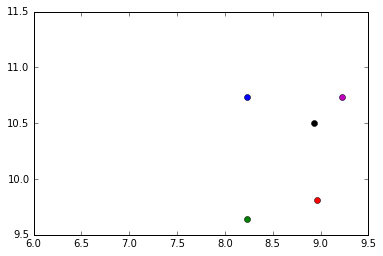

In [38]:
# Vocal DMP
for i in range(1):
    m = env.motor_babbling()
    m[28:42] = 0
    m[42:] = m[21:28]
    s_traj = env.diva.update(m[21:])
    plt.plot(s_traj[0][0], s_traj[0][1], "ok")
    plt.plot([f[0] for f in s_traj], [f[1] for f in s_traj])
    #plt.plot([f[1] for f in s_traj], "b")
    
    
plt.xlim([6., 9.5])
plt.ylim([9.5, 11.5])

plt.plot(f1_o, f2_o, "or")
plt.plot(f1_y, f2_y, "ob")
plt.plot(f1_u, f2_u, "og")
plt.plot(f1_e, f2_e, "om")